# Data Analysis

In [399]:
import pandas as pd
from functools import reduce
import numpy as np

from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid


In [400]:
DATE = "2025-09-30"

df_prices = pd.read_csv(f"data/{DATE}/prices.csv", parse_dates=["date"])
df_cash_rates = pd.read_csv(f"data/{DATE}/cash_rate.csv", parse_dates=["date"])
df_signals = pd.read_csv(f"data/{DATE}/signals.csv", parse_dates=["date"])
df_volumes = pd.read_csv(f"data/{DATE}/volumes.csv", parse_dates=["date"])

dfs = [df_prices, df_cash_rates, df_signals, df_volumes]

df = (
    reduce(
        lambda left, right: pd.merge(left, right, on="date", how="left"),
        dfs,
    )
    .sort_values("date")
    .reset_index(drop=True)
)

def add_periodic_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    date = pd.to_datetime(df["date"])

    day_of_week = date.dt.dayofweek
    day_of_year = date.dt.dayofyear
    month = date.dt.month
    week_of_year = date.dt.isocalendar().week.astype(int)

    df["dow_sin"] = np.sin(2 * np.pi * day_of_week / 7)
    df["dow_cos"] = np.cos(2 * np.pi * day_of_week / 7)
    df["doy_sin"] = np.sin(2 * np.pi * day_of_year / 365.25)
    df["doy_cos"] = np.cos(2 * np.pi * day_of_year / 365.25)
    df["month_sin"] = np.sin(2 * np.pi * month / 12)
    df["month_cos"] = np.cos(2 * np.pi * month / 12)
    df["woy_sin"] = np.sin(2 * np.pi * week_of_year / 52.18)
    df["woy_cos"] = np.cos(2 * np.pi * week_of_year / 52.18)
    return df

def add_instrument_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    for inst in [f"INSTRUMENT_{i}" for i in range(1, 11)]:
        px = df[inst].astype(float)
        ret_1 = px.pct_change()
        log_ret_1 = np.log(px).diff()

        df[f"{inst}_ret1"] = ret_1
        df[f"{inst}_logret1"] = log_ret_1
        df[f"{inst}_mom5"] = px.pct_change(5)
        df[f"{inst}_mom20"] = px.pct_change(20)
        df[f"{inst}_mom60"] = px.pct_change(60)
        df[f"{inst}_vol20"] = ret_1.rolling(20).std()
        df[f"{inst}_vol60"] = ret_1.rolling(60).std()
        df[f"{inst}_ma_ratio20"] = px / px.rolling(20).mean() - 1.0
        df[f"{inst}_ma_ratio60"] = px / px.rolling(60).mean() - 1.0

        vol_col = f"{inst}_vol"
        if vol_col in df.columns:
            log_vol = np.log1p(df[vol_col].astype(float))
            df[f"{inst}_logvol"] = log_vol
            df[f"{inst}_vol_z20"] = (
                (log_vol - log_vol.rolling(20).mean())
                / (log_vol.rolling(20).std() + 1e-12)
            )
            df[f"{inst}_vol_chg5"] = log_vol.diff(5)

    return df

df = add_periodic_date_features(df)
df = add_instrument_features(df)


/var/folders/zx/7nt78dzs2lbccbwfzr2blrrr0000gn/T/ipykernel_38853/1259425727.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{inst}_logret1"] = log_ret_1
/var/folders/zx/7nt78dzs2lbccbwfzr2blrrr0000gn/T/ipykernel_38853/1259425727.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{inst}_mom5"] = px.pct_change(5)
/var/folders/zx/7nt78dzs2lbccbwfzr2blrrr0000gn/T/ipykernel_38853/1259425727.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

In [401]:
print(len(df))
df.info()


3124
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3124 entries, 0 to 3123
Columns: 203 entries, date to INSTRUMENT_10_vol_chg5
dtypes: datetime64[ns](1), float64(192), int64(10)
memory usage: 4.8 MB


In [402]:
INSTRUMENTS = [f"INSTRUMENT_{i}" for i in range(1, 11)]
DATE_FEATURES = [
    "dow_sin", "dow_cos",
    "doy_sin", "doy_cos",
    "month_sin", "month_cos",
    "woy_sin", "woy_cos",
]
MACRO_FEATURES = [
    c for c in [
        "1mo", "1.5month", "2mo", "3mo", "4mo", "6mo",
        "1yr", "2yr", "3yr", "5yr", "7yr", "10yr", "20yr", "30yr",
    ]
    if c in df.columns and df[c].notna().mean() > 0.5
]


In [403]:
def softmax(x: np.ndarray):
    x = x - np.max(x)
    e = np.exp(x)
    return e / (e.sum() + 1e-12)

def cap_and_renorm(w: pd.Series, cap=0.25) -> pd.Series:
    w = w.clip(lower=0.0, upper=cap)
    s = float(w.sum())
    if s <= 0:
        return pd.Series(1.0 / len(w), index=w.index)
    return w / s

def build_feature_cols(df: pd.DataFrame, inst: str):
    own_cols = [
        col for col in df.columns
        if col == inst or col.startswith(f"{inst}_")
    ]
    cols = DATE_FEATURES + MACRO_FEATURES + own_cols
    return [col for col in cols if col in df.columns]


FORECAST_HORIZON = 252  # about 12 trading months

def make_labels_forward_return(df: pd.DataFrame, inst: str, horizon: int = FORECAST_HORIZON):
    x = df[inst].astype(float)
    return x.shift(-horizon) / x - 1.0



In [404]:
def train_predict_scores(
    df: pd.DataFrame,
    min_train: int = 750,
    val_size: int = 252,
    horizon: int = FORECAST_HORIZON,
):
    df = df.sort_values("date").reset_index(drop=True)

    param_grid = {
        "n_estimators": [300],
        "max_depth": [4, 5],
        "learning_rate": [0.03, 0.05],
        "subsample": [1.0],
        "colsample_bytree": [1.0],
        "reg_lambda": [3.0],
    }

    preds = {}
    fitted_models = {}
    validation_rows = []

    for inst in INSTRUMENTS:
        feat_cols = build_feature_cols(df, inst)
        X_all = df.iloc[:-horizon][feat_cols].copy()
        y_all = make_labels_forward_return(df, inst, horizon=horizon).iloc[:-horizon]

        mask = ~y_all.isna()
        X = X_all.loc[mask]
        y = y_all.loc[mask]

        if len(X) < min_train + val_size:
            preds[inst] = 0.0
            validation_rows.append(
                {
                    "instrument": inst,
                    "n_features": len(feat_cols),
                    "n_train": 0,
                    "n_val": 0,
                    "best_params": None,
                    "val_rmse": np.nan,
                    "val_corr": np.nan,
                    "val_hit_rate": np.nan,
                    "confidence": 0.0,
                }
            )
            continue

        X_train = X.iloc[:-val_size]
        y_train = y.iloc[:-val_size]
        X_val = X.iloc[-val_size:]
        y_val = y.iloc[-val_size:]

        best_params = None
        best_score = -np.inf

        for params in ParameterGrid(param_grid):
            model = XGBRegressor(
                objective="reg:squarederror",
                tree_method="hist",
                random_state=0,
                n_jobs=1,
                **params,
            )
            model.fit(X_train.values, y_train.values)

            val_pred = model.predict(X_val.values)
            val_corr = pd.Series(val_pred).corr(pd.Series(y_val.values))
            val_corr = 0.0 if pd.isna(val_corr) else float(val_corr)

            if val_corr > best_score:
                best_score = val_corr
                best_params = params

        final_model = XGBRegressor(
            objective="reg:squarederror",
            tree_method="hist",
            random_state=0,
            n_jobs=1,
            **best_params,
        )
        final_model.fit(X.values, y.values)

        val_pred = final_model.predict(X_val.values)
        val_rmse = float(np.sqrt(np.mean((val_pred - y_val.values) ** 2)))
        val_corr = pd.Series(val_pred).corr(pd.Series(y_val.values))
        val_corr = 0.0 if pd.isna(val_corr) else float(val_corr)
        val_hit_rate = float(((val_pred > 0) == (y_val.values > 0)).mean())

        confidence = max(val_corr, 0.0) * max(2.0 * (val_hit_rate - 0.5), 0.0)

        validation_rows.append(
            {
                "instrument": inst,
                "n_features": len(feat_cols),
                "n_train": len(X_train),
                "n_val": len(X_val),
                "best_params": best_params,
                "val_rmse": val_rmse,
                "val_corr": val_corr,
                "val_hit_rate": val_hit_rate,
                "confidence": confidence,
            }
        )

        x_last = df.loc[df.index[-1], feat_cols].astype(float)
        preds[inst] = float(final_model.predict([x_last.values])[0])
        fitted_models[inst] = final_model

    validation_df = pd.DataFrame(validation_rows).sort_values("confidence", ascending=False)
    confidence_series = validation_df.set_index("instrument")["confidence"].reindex(INSTRUMENTS).fillna(0.0)

    print("Validation results by instrument:")
    display(
        validation_df[
            [
                "instrument",
                "n_features",
                "n_train",
                "n_val",
                "val_rmse",
                "val_corr",
                "val_hit_rate",
                "confidence",
                "best_params",
            ]
        ].round(4)
    )

    print("\nAverage validation metrics:")
    display(
        validation_df[["val_rmse", "val_corr", "val_hit_rate", "confidence"]]
        .mean()
        .to_frame("mean")
        .T.round(4)
    )

    return fitted_models, pd.Series(preds), validation_df, best_params, confidence_series


In [405]:
models, pred, validation_df, best_params, confidence = train_predict_scores(df)

print("Best Parameters: ", best_params)

Validation results by instrument:


,instrument,n_features,n_train,n_val,val_rmse,val_corr,val_hit_rate,confidence,best_params
6,INSTRUMENT_7,38,2620,252,0.0097,0.9866,1.0000,0.9866,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
8,INSTRUMENT_9,38,2620,252,0.0730,0.9451,1.0000,0.9451,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
0,INSTRUMENT_1,38,2620,252,0.0171,0.9399,0.9762,0.8952,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
3,INSTRUMENT_4,38,2620,252,0.0263,0.9450,0.9603,0.8700,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
2,INSTRUMENT_3,38,2620,252,0.0276,0.9388,0.9603,0.8643,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
1,INSTRUMENT_2,38,2620,252,0.0214,0.9453,0.9246,0.8027,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
4,INSTRUMENT_5,38,2620,252,0.0134,0.9625,0.9167,0.8021,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
5,INSTRUMENT_6,38,2620,252,0.0054,0.9816,0.9008,0.7868,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
7,INSTRUMENT_8,38,2620,252,0.0261,0.9236,0.9167,0.7697,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."
9,INSTRUMENT_10,38,2620,252,0.1515,0.8142,0.8651,0.5945,"{'colsample_bytree': 1.0, 'learning_rate': 0.0..."



Average validation metrics:


,val_rmse,val_corr,val_hit_rate,confidence
mean,0.0372,0.9383,0.9421,0.8317


Best Parameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'reg_lambda': 3.0, 'subsample': 1.0}


In [406]:
# def train_predict_scores(
#     df: pd.DataFrame,
#     min_train: int = 750,
#     val_size: int = 252,
#     verbose = True
# ):
#     df = df.sort_values("date").reset_index(drop=True)

#     param_grid = {
#         "n_estimators": [150, 300],
#         "max_depth": [4, 5],
#         "learning_rate": [0.03, 0.05],
#         "subsample": [1.0], #[0.8, 1.0],
#         "colsample_bytree": [1.0], #[0.8, 1.0],
#         "reg_lambda": [1.0, 3.0, 5.0],
#     }

#     preds = {}
#     validation_rows = []
#     fitted_models = {}

#     for inst in INSTRUMENTS:
#         feat_cols = build_feature_cols(df, inst)
#         X_all = df.iloc[:-1][feat_cols].copy()
#         y_all = make_labels_next_return(df, inst).iloc[:-1]

#         mask = ~y_all.isna()
#         X = X_all.loc[mask]
#         y = y_all.loc[mask]

#         if len(X) < min_train + val_size:
#             preds[inst] = 0.0
#             validation_rows.append(
#                 {
#                     "instrument": inst,
#                     "n_features": len(feat_cols),
#                     "n_train": 0,
#                     "n_val": 0,
#                     "best_params": None,
#                     "val_rmse": np.nan,
#                     "val_corr": np.nan,
#                     "val_hit_rate": np.nan,
#                 }
#             )
#             continue

#         X_train = X.iloc[:-val_size]
#         y_train = y.iloc[:-val_size]
#         X_val = X.iloc[-val_size:]
#         y_val = y.iloc[-val_size:]

#         best_params = None
#         best_score = -np.inf

#         for params in ParameterGrid(param_grid):
#             model = XGBRegressor(
#                 objective="reg:squarederror",
#                 tree_method="hist",
#                 random_state=0,
#                 n_jobs=4,
#                 **params,
#             )
#             model.fit(X_train.values, y_train.values)

#             val_pred = model.predict(X_val.values)
#             val_corr = pd.Series(val_pred).corr(pd.Series(y_val.values))
#             val_corr = 0.0 if pd.isna(val_corr) else float(val_corr)

#             if val_corr > best_score:
#                 best_score = val_corr
#                 best_params = params

#         final_model = XGBRegressor(
#             objective="reg:squarederror",
#             tree_method="hist",
#             random_state=0,
#             n_jobs=1,
#             **best_params,
#         )
#         final_model.fit(X.values, y.values)

#         val_pred = final_model.predict(X_val.values)
#         val_rmse = float(np.sqrt(np.mean((val_pred - y_val.values) ** 2)))
#         val_corr = pd.Series(val_pred).corr(pd.Series(y_val.values))
#         val_corr = 0.0 if pd.isna(val_corr) else float(val_corr)
#         val_hit_rate = float(((val_pred > 0) == (y_val.values > 0)).mean())

#         validation_rows.append(
#             {
#                 "instrument": inst,
#                 "n_features": len(feat_cols),
#                 "n_train": len(X_train),
#                 "n_val": len(X_val),
#                 "best_params": best_params,
#                 "val_rmse": val_rmse,
#                 "val_corr": val_corr,
#                 "val_hit_rate": val_hit_rate,
#             }
#         )

#         x_last = df.loc[df.index[-1], feat_cols].astype(float)
#         preds[inst] = float(final_model.predict([x_last.values])[0])
#         fitted_models[inst] = final_model

#     validation_df = pd.DataFrame(validation_rows).sort_values("val_corr", ascending=False)
#     confidence_series = (
#         validation_df.set_index("instrument")["val_corr"]
#         .reindex(INSTRUMENTS)
#         .fillna(0.0)
#     )
#     if verbose:
#         print("Validation results by instrument:")
#         display(
#             validation_df[
#                 [
#                     "instrument",
#                     "n_features",
#                     "n_train",
#                     "n_val",
#                     "val_rmse",
#                     "val_corr",
#                     "val_hit_rate",
#                     "best_params",
#                 ]
#             ].round(4)
#         )

#     print("\nAverage validation metrics:")
#     display(
#         validation_df[["val_rmse", "val_corr", "val_hit_rate"]]
#         .mean()
#         .to_frame("mean")
#         .T.round(4)
#     )

#     return fitted_models, pd.Series(preds), validation_df, best_params, confidence_series

# models, pred, validation_df, best_params, confidence = train_predict_scores(df)

# print("Best Parameters: ", best_params)


In [407]:
print(confidence)

instrument
INSTRUMENT_1     0.895165
INSTRUMENT_2     0.802722
INSTRUMENT_3     0.864282
INSTRUMENT_4     0.869987
INSTRUMENT_5     0.802092
INSTRUMENT_6     0.786844
INSTRUMENT_7     0.986568
INSTRUMENT_8     0.769664
INSTRUMENT_9     0.945144
INSTRUMENT_10    0.594517
Name: confidence, dtype: float64


In [408]:
import numpy as np
from scipy.optimize import minimize

def solve_mean_variance(mu, Sigma, lam):
    """
    mu:     (n,) expected returns
    Sigma:  (n,n) covariance matrix
    lam:    risk aversion parameter λ
    """
    n = len(mu)

    # Objective function
    def objective(w):
        return -w @ mu + 0.5 * lam * w @ Sigma @ w

    # Gradient (important for speed & stability)
    def grad(w):
        return -mu + lam * Sigma @ w

    # Equality constraint: sum w_i = 1
    constraints = ({
        'type': 'eq',
        'fun': lambda w: np.sum(w) - 1.0,
        'jac': lambda w: np.ones(n)
    })

    # Bounds: w_i >= 0
    bounds = [(0.0, None) for _ in range(n)]

    # Initial guess (uniform portfolio)
    w0 = np.ones(n) / n

    result = minimize(
        objective,
        w0,
        method='SLSQP',
        jac=grad,
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-9, 'disp': True}
    )

    if not result.success:
        raise RuntimeError(result.message)

    return result.x

In [409]:
def construct_weights(
    pred: pd.Series,
    confidence: float | pd.Series,
    beta=7.0,
    cap=0.25,
    smooth_alpha=1.0,
    prev_weights: pd.Series | None = None,
):
    scores = pred.copy()

    # allow scalar or per-asset confidence
    if isinstance(confidence, pd.Series):
        conf = confidence.reindex(INSTRUMENTS).fillna(0.0)
        logits = beta * conf * scores 
    else:
        logits = beta * confidence * scores

    w = pd.Series(softmax(logits.values), index=INSTRUMENTS)
    w = cap_and_renorm(w, cap=cap)

    if prev_weights is not None:
        prev_weights = prev_weights.reindex(INSTRUMENTS).fillna(0.0)
        prev_weights = prev_weights / prev_weights.sum()
        w = smooth_alpha * w + (1.0 - smooth_alpha) * prev_weights
        w = cap_and_renorm(w, cap=cap)

    return w

def write_submission(weights: pd.Series, team_name: str, round_n: int, out_path="."):
    out = pd.DataFrame({"asset": weights.index, "weight": weights.values})
    fname = f"{team_name}_round_{round_n}.csv"
    out.to_csv(f"{out_path}/{fname}", index=False)
    return fname

w_init = construct_weights(pred, confidence)

In [410]:
price_log = pd.read_csv(f"data/{DATE}/prices.csv")
price_log = price_log.set_index('date')
price_log = np.log(price_log)

returns_log = price_log - price_log.shift()
returns_log.cov().values

array([[ 9.74069159e-05,  1.12608478e-04,  7.74928949e-05,
         8.00407575e-05, -1.24306766e-05, -4.58837743e-06,
         6.30055933e-06,  6.15929765e-05,  9.32224547e-05,
         1.28080448e-04],
       [ 1.12608478e-04,  1.49098707e-04,  8.52447342e-05,
         9.55534793e-05, -1.02606384e-05, -3.70316236e-06,
         8.81107894e-06,  5.69287231e-05,  1.17817504e-04,
         1.60868932e-04],
       [ 7.74928949e-05,  8.52447342e-05,  8.50096544e-05,
         8.21464220e-05, -8.41008324e-06, -2.41754952e-06,
         1.45085287e-05,  5.61571320e-05,  8.60876393e-05,
         1.18933620e-04],
       [ 8.00407575e-05,  9.55534793e-05,  8.21464220e-05,
         1.15722562e-04, -9.72689456e-06, -3.50333270e-06,
         1.73600718e-05,  6.59164175e-05,  9.07186517e-05,
         1.30403112e-04],
       [-1.24306766e-05, -1.02606384e-05, -8.41008324e-06,
        -9.72689456e-06,  6.57543467e-05,  2.66675449e-05,
         1.70722087e-05, -2.67868490e-05, -4.33273548e-06,
        -4.

In [411]:
import matplotlib.pyplot as plt

In [412]:
lambdas = [2000, 2500, 5000, 10000]

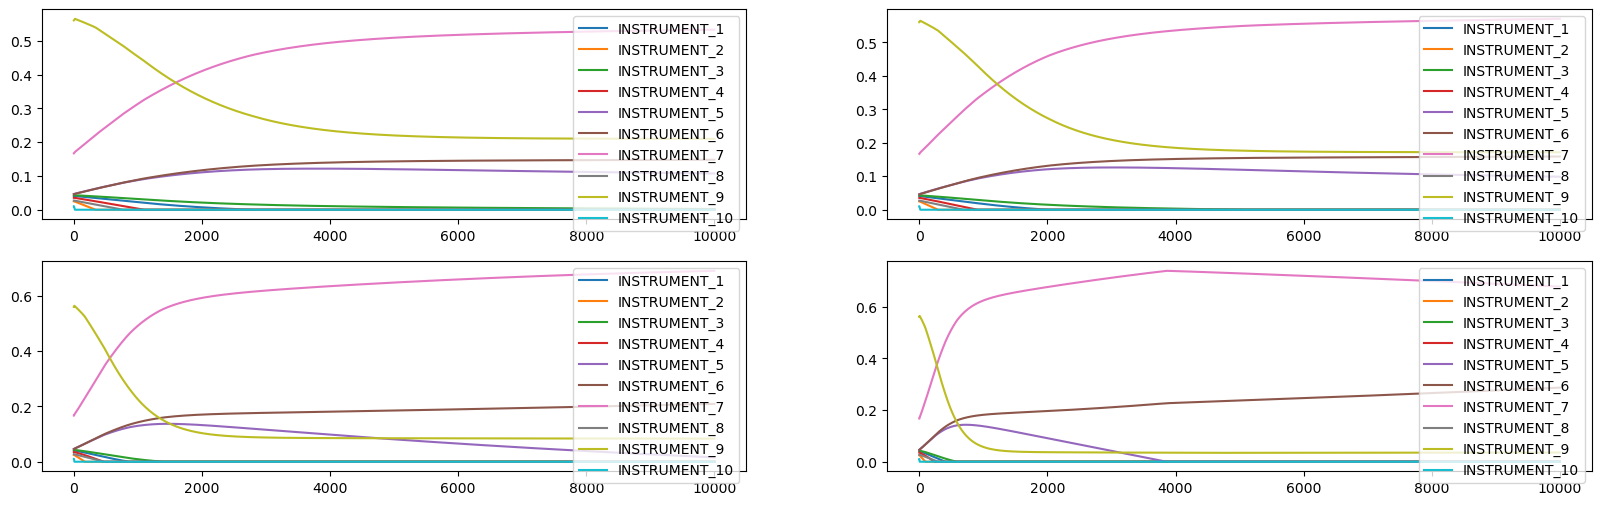

In [413]:
fig, axes = plt.subplots(2, len(lambdas) // 2, figsize=(20, 6))


for iter_num, lam in enumerate(lambdas):
    w_new = w_init.copy()
    r = pred.copy().values

    prices = pd.read_csv(f"data/{DATE}/prices.csv").set_index('date')
    returns = prices/prices.shift(1) - 1
    sigma = returns.cov().values
    # display(pred)

    def gradient(w: np.ndarray, sigma: np.ndarray, r: np.ndarray) -> np.ndarray:
        return r - lam * (sigma @ w).T

    param = 4.0
    last_time = 0.0

    weights_t = [w_new]

    for time in np.linspace(0, 1, 10000):
        dt = time - last_time
        w_new = w_new + param * dt * gradient(w_new, sigma, r) 
        w_new = np.clip(w_new, a_min=0.0, a_max=None)
        w_new /= w_new.sum()

        last_time = time
        weights_t.append(w_new.copy())

    weights_t = pd.concat([x.to_frame().T for x in weights_t], axis=0, ignore_index=True)
    weights_t.plot(ax=axes.flatten()[iter_num])

    fname = write_submission(weights_t.iloc[-1], team_name="HiddenLabel", round_n=lam, out_path=".")


In [414]:
pd.concat((pred.rename('pred'), w_init.rename('original'), weights_t.iloc[500], weights_t.iloc[-1]), axis=1)

,pred,original,500,10000
INSTRUMENT_1,0.036395,0.040540,0.000000,0.000000
INSTRUMENT_2,-0.046104,0.024908,0.000000,0.000000
INSTRUMENT_3,0.046168,0.042673,0.005273,0.000000
INSTRUMENT_4,0.014453,0.035243,0.000000,0.000000
INSTRUMENT_5,0.064637,0.046393,0.135370,0.000000
INSTRUMENT_6,0.063471,0.045779,0.149662,0.286718
INSTRUMENT_7,0.237931,0.166898,0.511430,0.677719
INSTRUMENT_8,-0.032899,0.027031,0.000000,0.000000
INSTRUMENT_9,0.607923,0.560261,0.198265,0.035563
INSTRUMENT_10,-0.275051,0.010274,0.000000,0.000000


<Axes: xlabel='date'>

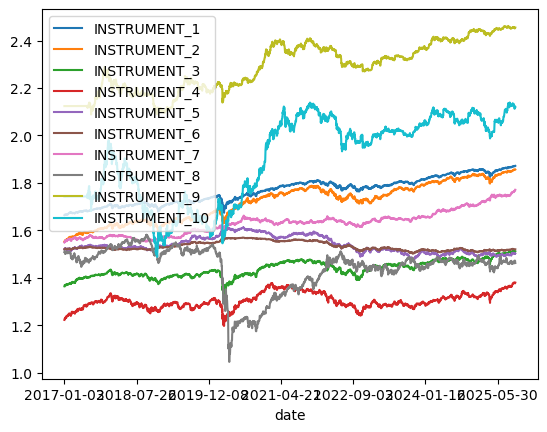

In [415]:
# df_prices.set_index('date')
np.log(price_log).plot()

In [416]:
weights_t

,INSTRUMENT_1,INSTRUMENT_2,INSTRUMENT_3,INSTRUMENT_4,INSTRUMENT_5,INSTRUMENT_6,INSTRUMENT_7,INSTRUMENT_8,INSTRUMENT_9,INSTRUMENT_10
0,0.040540,0.024908,0.042673,0.035243,0.046393,0.045779,0.166898,0.027031,0.560261,0.010274
1,0.040540,0.024908,0.042673,0.035243,0.046393,0.045779,0.166898,0.027031,0.560261,0.010274
2,0.040575,0.024731,0.042743,0.035228,0.046735,0.046118,0.168057,0.027029,0.561525,0.007258
3,0.040610,0.024553,0.042813,0.035213,0.047078,0.046458,0.169219,0.027027,0.562789,0.004240
4,0.040645,0.024374,0.042884,0.035198,0.047421,0.046798,0.170383,0.027024,0.564052,0.001219
...,...,...,...,...,...,...,...,...,...,...
9996,0.000000,0.000000,0.000000,0.000000,0.000000,0.286674,0.677764,0.000000,0.035562,0.000000
9997,0.000000,0.000000,0.000000,0.000000,0.000000,0.286685,0.677753,0.000000,0.035562,0.000000
9998,0.000000,0.000000,0.000000,0.000000,0.000000,0.286696,0.677741,0.000000,0.035563,0.000000
9999,0.000000,0.000000,0.000000,0.000000,0.000000,0.286707,0.677730,0.000000,0.035563,0.000000


In [417]:
n_days = 1

returns = prices / prices.shift(n_days) - 1

cov = returns.cov() * 365 / n_days
display(cov)

diag = pd.Series(np.diag(cov), index=cov.index)
display(pd.concat((pred.rename('pred'), diag.rename('var')), axis=1).assign(z_score=lambda x: x['pred'] / np.sqrt(x['var'])))

,INSTRUMENT_1,INSTRUMENT_2,INSTRUMENT_3,INSTRUMENT_4,INSTRUMENT_5,INSTRUMENT_6,INSTRUMENT_7,INSTRUMENT_8,INSTRUMENT_9,INSTRUMENT_10
INSTRUMENT_1,0.035398,0.040954,0.028060,0.028948,-0.004546,-0.001664,0.002314,0.021527,0.032516,0.044908
INSTRUMENT_2,0.040954,0.054274,0.030902,0.034629,-0.003735,-0.001337,0.003234,0.019892,0.041544,0.056946
INSTRUMENT_3,0.028060,0.030902,0.030732,0.029656,-0.003072,-0.000872,0.005292,0.019554,0.029645,0.041232
INSTRUMENT_4,0.028948,0.034629,0.029656,0.041883,-0.003574,-0.001273,0.006321,0.022984,0.031484,0.045576
INSTRUMENT_5,-0.004546,-0.003735,-0.003072,-0.003574,0.024021,0.009740,0.006231,-0.009692,-0.001449,-0.001610
INSTRUMENT_6,-0.001664,-0.001337,-0.000872,-0.001273,0.009740,0.004776,0.003507,-0.004068,-0.000262,-0.000334
INSTRUMENT_7,0.002314,0.003234,0.005292,0.006321,0.006231,0.003507,0.020734,0.005798,0.009500,0.011383
INSTRUMENT_8,0.021527,0.019892,0.019554,0.022984,-0.009692,-0.004068,0.005798,0.149073,0.015342,0.024209
INSTRUMENT_9,0.032516,0.041544,0.029645,0.031484,-0.001449,-0.000262,0.009500,0.015342,0.452831,0.451514
INSTRUMENT_10,0.044908,0.056946,0.041232,0.045576,-0.001610,-0.000334,0.011383,0.024209,0.451514,0.746388


,pred,var,z_score
INSTRUMENT_1,0.036395,0.035398,0.193444
INSTRUMENT_2,-0.046104,0.054274,-0.197899
INSTRUMENT_3,0.046168,0.030732,0.263359
INSTRUMENT_4,0.014453,0.041883,0.070623
INSTRUMENT_5,0.064637,0.024021,0.417052
INSTRUMENT_6,0.063471,0.004776,0.918398
INSTRUMENT_7,0.237931,0.020734,1.652387
INSTRUMENT_8,-0.032899,0.149073,-0.085208
INSTRUMENT_9,0.607923,0.452831,0.903401
INSTRUMENT_10,-0.275051,0.746388,-0.318370


## Fine Tune Lambda

l=2000 expected_returns=0.001002905681332084 std_returns=0.007072272405376386 sharpe=2.2644941419988656
l=2500 expected_returns=0.0010282892918616043 std_returns=0.00690841326073184 sharpe=2.3768791135311775
l=5000 expected_returns=0.0011324471152289197 std_returns=0.007152704394950971 sharpe=2.5282367683011318
l=10000 expected_returns=0.0010936908252641455 std_returns=0.0068916344843291035 sharpe=2.5342089693680507


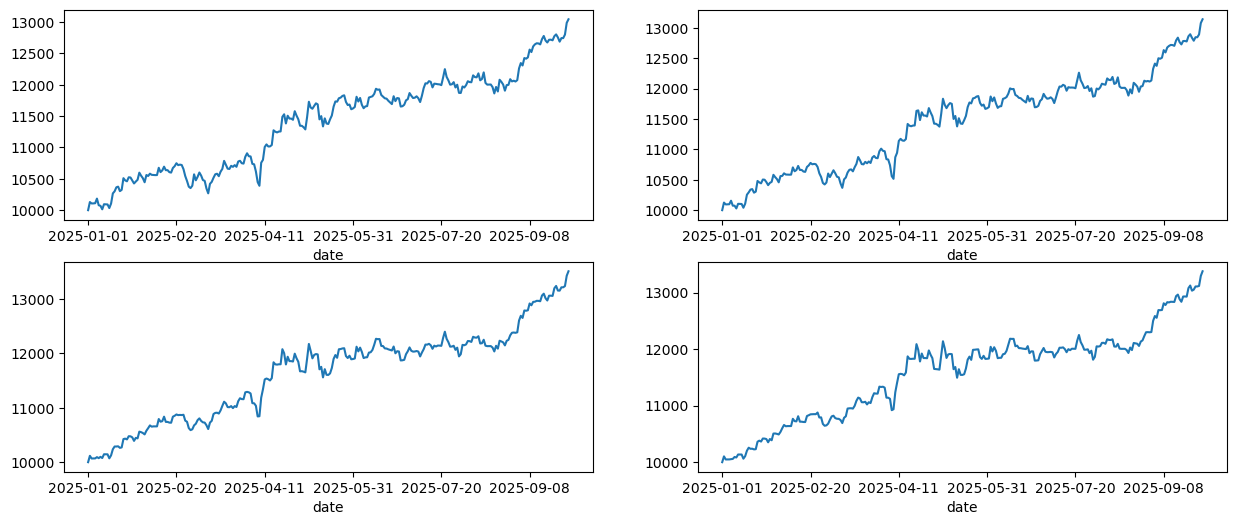

In [418]:

fig, axes = plt.subplots(2, len(lambdas) // 2, figsize=(15, 6))

new_date = "2025-09-30"
scratch_df = pd.read_csv(f"data/{new_date}/prices.csv").set_index('date')
date_start = "2025-01-01" # scratch_df.index[-500]
scratch_df = scratch_df.loc[date_start:]

for i, l in enumerate(lambdas):

    df = pd.read_csv(f"HiddenLabel_round_{l}.csv").set_index("asset")
    w_test = df["weight"]

    initial_notional = 10_000
    shares_per_asset = initial_notional * w_test / scratch_df.iloc[0]

    notional = np.sum(shares_per_asset * scratch_df, axis=1)
    notional.plot(ax=axes.flatten()[i])

    strategy_returns = notional / notional.shift() - 1.0
    expected_returns = float(np.mean(strategy_returns))
    std_returns = float(np.std(strategy_returns))

    print(f'{l=} {expected_returns=} {std_returns=} sharpe={(expected_returns / std_returns) * np.sqrt(255)}')

chosen = 5000

<Axes: xlabel='date'>

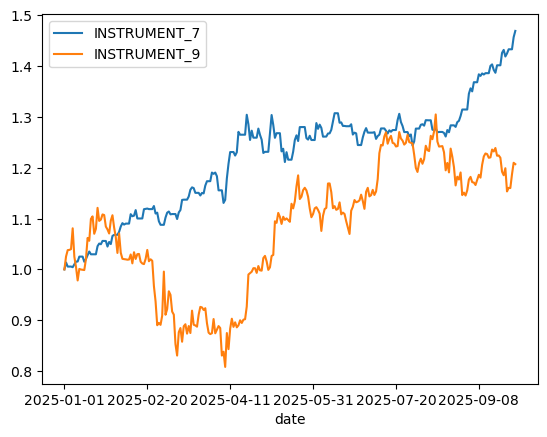

In [419]:
(scratch_df / scratch_df.iloc[0]).iloc[:, [6, 8]].plot()

In [420]:
scratch_df

,INSTRUMENT_1,INSTRUMENT_2,INSTRUMENT_3,INSTRUMENT_4,INSTRUMENT_5,INSTRUMENT_6,INSTRUMENT_7,INSTRUMENT_8,INSTRUMENT_9,INSTRUMENT_10
date,,,,,,,,,,
2025-01-01,581.98,510.77,75.39,41.68,85.93,92.69,242.70,76.68,94813.80,3381.39
2025-01-02,580.59,509.76,75.13,41.61,86.17,92.74,246.00,78.08,97221.69,3476.42
2025-01-03,587.89,518.06,75.46,42.01,85.89,92.59,244.05,79.08,98405.17,3629.16
2025-01-04,587.89,518.08,75.46,42.01,85.89,92.58,244.06,79.08,98453.46,3676.63
2025-01-05,587.87,518.10,75.46,42.01,85.88,92.58,244.06,79.09,98591.48,3655.97
...,...,...,...,...,...,...,...,...,...,...
2025-09-26,659.62,596.85,92.33,52.50,88.99,96.50,347.71,78.13,110011.97,4059.49
2025-09-27,659.58,596.86,92.33,52.50,88.99,96.50,347.72,78.11,109976.08,4044.44
2025-09-28,659.59,596.86,92.33,52.49,88.99,96.50,347.71,78.12,112528.67,4167.30


In [421]:
expected_returns / std_returns

0.1586983215304135